# Advanced Agentic RAG with LangGraph

**A portfolio project showcasing intelligent, adaptive retrieval pipelines**

This system demonstrates production-grade RAG architecture patterns:

- **Dynamic strategy selection** - Semantic, keyword, or hybrid retrieval based on query analysis
- **Quality-driven self-correction** - Automatic query rewrites when retrieval quality is insufficient
- **Multi-stage reranking** - CrossEncoder (top-10) + LLM-as-judge (top-4) for precision
- **HHEM-based hallucination detection** - Claim decomposition with per-chunk HHEM-2.1-Open verification
- **Multi-agent parallel retrieval** - Query decomposition with parallel workers for complex questions

**Architecture**: 7-node StateGraph with distributed intelligence (no central orchestrator)  
**Framework**: LangChain 1.0 & LangGraph 1.0  
**Pattern**: Dynamic Planning and Execution Agents

In [1]:
# Setup & Imports
import os
from dotenv import load_dotenv
load_dotenv()

# All RAG graph variants
from advanced_agentic_rag_langgraph.variants import (
    basic_rag_graph,
    intermediate_rag_graph,
    advanced_rag_graph,
    multi_agent_rag_graph,
)

print("RAG variants loaded:")
print("  - basic_rag_graph: Simplest RAG (semantic search only)")
print("  - intermediate_rag_graph: Query expansion + hybrid + reranking")
print("  - advanced_rag_graph: Full agentic RAG with self-correction")
print("  - multi_agent_rag_graph: Parallel retrieval workers")

RAG variants loaded:
  - basic_rag_graph: Simplest RAG (semantic search only)
  - intermediate_rag_graph: Query expansion + hybrid + reranking
  - advanced_rag_graph: Full agentic RAG with self-correction
  - multi_agent_rag_graph: Parallel retrieval workers


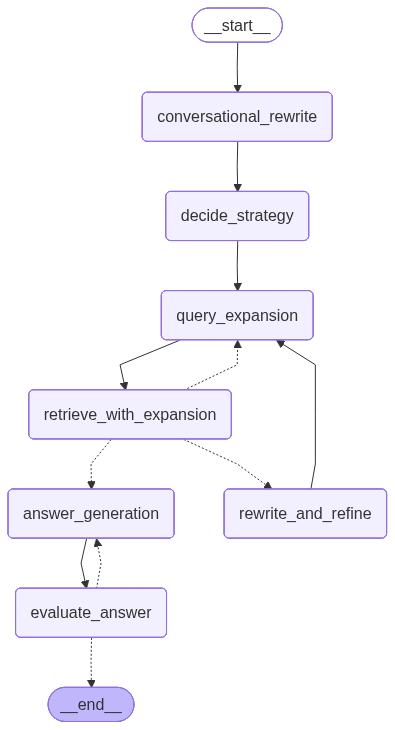

In [2]:
# Architecture Diagram - LangGraph Mermaid Visualization
from IPython.display import Image

# Render the Advanced RAG graph structure
Image(advanced_rag_graph.get_graph().draw_mermaid_png())

## Routing Logic (What the Diagram Doesn't Show)

The graph visualization shows nodes and edges, but the **conditional routing logic** is where the "intelligence" lives:

### `route_after_retrieval` - Quality-Based Branching
```python
if quality >= 0.6:
    return "answer_generation"  # Good enough - proceed

if attempts >= 2:
    return "answer_generation"  # Max attempts - proceed anyway

if ("off_topic" in issues or "wrong_domain" in issues) and (attempts == 1):
    return "query_expansion"    # Early strategy switch
else:
    return "rewrite_and_refine" # Semantic rewrite
```

### `route_after_evaluation` - Answer Quality Gate
```python
if is_refusal:
    return END  # LLM refused - terminal state

if is_answer_sufficient:
    return END

if generation_attempts < 3:
    return "answer_generation"  # Retry with feedback
else:
    return END  # Max attempts reached
```

### Key Design Principles
- **Fix generation with generation** - Don't re-retrieve for generation problems
- **Single correction cycle** - Research shows diminishing returns after first retry
- **Adaptive thresholds** - Lower quality bar (50%) when retrieval is poor

In [3]:
# Initialize Retriever (one-time setup)
# This loads 10 research papers and creates the vector store
from advanced_agentic_rag_langgraph.core import setup_retriever

k_final=4
retriever = setup_retriever(k_final=k_final)
print("\nRetriever initialized with 10 research papers (924 chunks)")
print("Papers include: Transformers, BERT, ViT, DDPM, CLIP, U-Net, WGAN-GP, Consistency Models")


LOADING ALL PDFS FROM docs/

Found 10 PDF file(s):
  1. AN IMAGE IS WORTH 16X16 WORDS - TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE.pdf (3.6 MB)
  2. Attention Is All You Need.pdf (2.1 MB)
  3. BERT - Pre-training of Deep Bidirectional Transformers for Language Understanding.pdf (0.7 MB)
  4. Consistency Models - faster alternative to traditional diffusion models; directly mapping noise to data.pdf (30.1 MB)
  5. Denoising Diffusion Probabilistic Models.pdf (9.8 MB)
  6. Expanding Horizons in RAG - Exploring and Extending the Limits of RAPTOR.pdf (0.6 MB)
  7. Hierarchical Text-Conditional Image Generation with CLIP Latents.pdf (40.9 MB)
  8. Improved Training of Wasserstein GANs.pdf (5.9 MB)
  9. Learning Transferable Visual Models From Natural Language Supervision.pdf (6.5 MB)
  10. U-Net - Convolutional Networks for Biomedical Image Segmentation.pdf (1.6 MB)

STEP 1: Loading full documents (no chunking)


Loading 10 PDFs as full documents (no chunking)...
Loading full document: AN 

## 4-Tier Architecture Comparison

Each tier adds capabilities while using the **same budget model tier** (GPT-4o-mini) to isolate architectural improvements from model quality:

| Tier | Features | Key Additions |
|------|----------|---------------|
| **Basic** | 1 | Semantic search only, direct LLM generation |
| **Intermediate** | 5 | + Query expansion, hybrid retrieval, CrossEncoder reranking, RRF fusion |
| **Advanced** | 17 | + Strategy selection, two-stage reranking, HHEM detection, quality gates, self-correction loops |
| **Multi-Agent** | 20 | + Query decomposition, parallel retrieval workers, cross-agent LLM relevance scoring |

### Feature Progression
- **Basic**: Pure semantic similarity - works well for simple, direct questions
- **Intermediate**: Query variations improve recall, reranking improves precision
- **Advanced**: Adapts strategy based on query type, retries on poor results
- **Multi-Agent**: Decomposes complex questions, retrieves in parallel, merges results

In [ ]:
# Run 4-Tier Comparison
# Using a query from golden dataset so we can calculate F1@4

from advanced_agentic_rag_langgraph.evaluation.retrieval_metrics import calculate_retrieval_metrics
from advanced_agentic_rag_langgraph.validation import HHEMHallucinationDetector

# Import modules to inject shared retriever
import advanced_agentic_rag_langgraph.variants.basic_rag_graph as basic_module
import advanced_agentic_rag_langgraph.variants.intermediate_rag_graph as intermediate_module
import advanced_agentic_rag_langgraph.orchestration.nodes as advanced_module
import advanced_agentic_rag_langgraph.variants.multi_agent_rag_graph as multi_agent_module

# Inject pre-built retriever into all variants
basic_module.adaptive_retriever = retriever
intermediate_module.adaptive_retriever = retriever
advanced_module.adaptive_retriever = retriever
multi_agent_module.adaptive_retriever = retriever

# Query from golden_set_standard.json (transformer_training_procedure)
test_query = "Describe the complete training procedure for the Transformer, including optimization, regularization, and learning rate schedule."
ground_truth_doc_ids = [
      "Attention Is All You Need.pdf_chunk_28",
      "Attention Is All You Need.pdf_chunk_29",
      "Attention Is All You Need.pdf_chunk_30",
      "Attention Is All You Need.pdf_chunk_31"
]

graphs = {
    "Basic": basic_rag_graph,
    "Intermediate": intermediate_rag_graph,
    "Advanced": advanced_rag_graph,
    "Multi-Agent": multi_agent_rag_graph,
}

print(f"Query: {test_query}")
print(f"Ground Truth Chunks: {len(ground_truth_doc_ids)} (from attention paper)")
print("="*80)

results = {}
for name, graph in graphs.items():
    print(f"\nRunning {name} RAG...")
    
    initial_state = {
        "user_question": test_query,
        "baseline_query": test_query,
        "messages": [],
        "retrieved_docs": [],
        "retrieval_attempts": 0,
        "query_expansions": [],
        "sub_agent_results": [],
        "ground_truth_doc_ids": ground_truth_doc_ids,
    }
    config = {"configurable": {"thread_id": f"demo-{name.lower().replace('-', '_')}"}}
    
    result = graph.invoke(initial_state, config=config)
    results[name] = result
    
    # Calculate F1@4 for progress display
    docs = result.get("unique_docs_list", [])
    if docs:
        metrics = calculate_retrieval_metrics(docs, ground_truth_doc_ids, k_final)
        f1 = metrics["f1_at_k"]
    else:
        f1 = 0.0
    print(f"  F1@{k_final}: {f1:.0%}")

print("\n" + "="*80)
print("Comparison complete!")

Query: Describe the complete training procedure for the Transformer, including optimization, regularization, and learning rate schedule.
Ground Truth Chunks: 4 (from attention paper)

Running Basic RAG...

BASIC RETRIEVAL
Strategy: semantic only (vector similarity)
Top-K: 4 chunks (no reranking)
Retrieved: 4 documents

All 4 chunk IDs (rank order):
  1. Attention Is All You Need.pdf_chunk_6
  2. Learning Transferable Visual Models From Natural Language Supervision.pdf_chunk_31
  3. Attention Is All You Need.pdf_chunk_10
  4. AN IMAGE IS WORTH 16X16 WORDS - TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE.pdf_chunk_69

Expected chunks: ['Attention Is All You Need.pdf_chunk_28', 'Attention Is All You Need.pdf_chunk_29', 'Attention Is All You Need.pdf_chunk_30', 'Attention Is All You Need.pdf_chunk_31']
Found: [] | Missing: ['Attention Is All You Need.pdf_chunk_28', 'Attention Is All You Need.pdf_chunk_29', 'Attention Is All You Need.pdf_chunk_30', 'Attention Is All You Need.pdf_chunk_31']


A

In [5]:
# Display Comparison Results
# Calculate F1@4 and Groundedness independently (not from graph state)

hhem_detector = HHEMHallucinationDetector()

print("=" * 80)
print("4-TIER ARCHITECTURE COMPARISON RESULTS")
print("=" * 80)

for name, result in results.items():
    strategy = result.get("retrieval_strategy", "semantic") or "semantic"
    docs = result.get("unique_docs_list", [])
    answer = result.get("final_answer", "")

    # Calculate F1@4 using ground truth
    if docs:
        metrics = calculate_retrieval_metrics(docs, ground_truth_doc_ids, k_final)
        f1_at_k = metrics["f1_at_k"]
    else:
        f1_at_k = 0.0

    # Calculate groundedness using HHEM
    if docs and answer:
        chunks = [doc.page_content for doc in docs[:k_final]]
        groundedness_result = hhem_detector.verify_groundedness(answer, chunks)
        groundedness = groundedness_result["groundedness_score"]
    else:
        groundedness = 0.0

    print(f"\n[{name.upper()}]")
    print(f"Strategy: {strategy}  |  Docs: {len(docs)}  |  F1@4: {f1_at_k:.0%}  |  Groundedness: {groundedness:.0%}")
    print("-" * 80)
    print(answer if answer else "No answer")
    print("=" * 80)

print("\nKey Observations:")
print("- F1@4 measures retrieval quality against known ground truth chunks")
print("- Groundedness measures % of answer claims supported by retrieved context (via HHEM)")
print("- Multi-Agent shows best F1@4 due to query decomposition finding more relevant chunks")

4-TIER ARCHITECTURE COMPARISON RESULTS

[BASIC]
Strategy: semantic  |  Docs: 4  |  F1@4: 0%  |  Groundedness: 64%
--------------------------------------------------------------------------------
The complete training procedure for the Transformer involves several key components, including optimization, regularization, and learning rate scheduling. Here’s a detailed description:

1. **Optimizer**: The Adam optimizer is used for training the Transformer model. Adam is known for its efficiency and effectiveness in handling sparse gradients and is well-suited for a variety of training tasks.

2. **Weight Regularization**: The model employs decoupled weight decay regularization. This technique is applied to all weights in the model that are not gains or biases, helping to prevent overfitting by penalizing large weights.

3. **Learning Rate Schedule**: The learning rate is adjusted using a cosine schedule. This means that the learning rate starts at a certain value and gradually decreases fo

## Deep Dive: Self-Correction Loops

The Advanced RAG tier implements two self-correction mechanisms:

### 1. Retrieval Correction (max 2 attempts)
When `retrieval_quality_score < 0.6`:
- **Path A (off_topic/wrong_domain)**: Switch strategy immediately (semantic ↔ keyword)
- **Path B (other issues)**: Inject suggested keywords into query for better term coverage

### 2. Generation Retry (max 3 attempts)
When answer fails quality evaluation:
- Regenerate with combined feedback (quality issues + hallucination warnings)
- Low temperature: 0.3

### Why Single Correction Cycle?
Research (CRAG, Self-RAG) shows diminishing returns after the first correction. The architecture accepts imperfect retrieval rather than looping indefinitely.

In [ ]:
# Self-Correction Example
# This query might trigger self-correction due to cross-domain scope

correction_query = "How is attention mechanism used differently in NLP vs vision models?"

print(f"Query: {correction_query}")
print("="*80)
print("\nRunning Advanced RAG with potential self-correction...\n")

initial_state = {
    "user_question": correction_query,
    "baseline_query": correction_query,
    "messages": [],
    "retrieved_docs": [],
    "retrieval_attempts": 0,
    "query_expansions": [],
}
config = {"configurable": {"thread_id": "demo-selfcorrect"}}

result = advanced_rag_graph.invoke(initial_state, config=config)

# Display self-correction trace
print("\n\n" + "="*80)
print("EXECUTION TRACE")
print("-"*40)
print(f"Retrieval Attempts: {result.get('retrieval_attempts', 1)}")
print(f"Strategy Used: {result.get('retrieval_strategy', 'semantic')}")

if result.get('strategy_changed'):
    print(f"Strategy Changed: Yes")
    print(f"  Reason: {result.get('strategy_switch_reason', 'N/A')}")

quality = result.get('retrieval_quality_score', 0) or 0
print(f"Final Retrieval Quality: {quality:.0%}")

if result.get('retrieval_quality_issues'):
    print(f"Issues Detected: {', '.join(result['retrieval_quality_issues'])}")

if result.get('retrieval_improvement_suggestion'):
    print(f"Improvement Suggestion: {result['retrieval_improvement_suggestion']}")

print(f"\nGeneration Attempts: {result.get('generation_attempts', 1)}")
print(f"Groundedness: {(result.get('groundedness_score', 0) or 0):.0%}")
print(f"Answer Sufficient: {result.get('is_answer_sufficient', True)}")

print("\n" + "="*80)
print("ANSWER:")
print("-"*40)
print(result.get('final_answer', 'No answer'))

Query: How is attention mechanism used differently in NLP vs vision models?

Running Advanced RAG with potential self-correction...


STRATEGY SELECTION
Query: How is attention mechanism used differently in NLP vs vision models?
Selected: HYBRID
Confidence: 90%
Reasoning: The user is seeking a comparison between the use of attention mechanisms in NLP and vision models, which indicates a need for both conceptual understanding (how attention mechanisms function in each domain) and specific terms (NLP and vision models). This makes a hybrid search the best choice, as it allows for retrieving documents that explain the differences while also ensuring that the exact terms 'NLP' and 'vision models' are matched accurately. The corpus is technical and focused on computer vision, which supports the need for precise retrieval of relevant technical content.
Note: Query optimization will happen in query_expansion_node


STRATEGY-SPECIFIC QUERY OPTIMIZATION
Strategy: hybrid
Original query: How is a

## Evaluation Metrics Summary

All tiers use **budget models** (GPT-4o-mini only) to isolate architectural improvements from model quality.

### Standard Dataset (20 questions, k=4)

| Tier | Precision@4 | Recall@4 | F1@4 | MRR | nDCG@4 |
|------|-------------|----------|------|-----|--------|
| Basic | 10.0% | 23.8% | 13.1% | 0.204 | 0.191 |
| Intermediate | 17.5% | 40.0% | 23.0% | 0.425 | 0.384 |
| Advanced | 20.0% | 43.3% | 25.9% | 0.550 | 0.443 |
| **Multi-Agent** | **23.8%** | **47.1%** | **29.6%** | **0.558** | **0.464** |

### Hard Dataset (10 questions, k=6, multi-document)

| Tier | Precision@6 | Recall@6 | F1@6 | MRR | nDCG@6 |
|------|-------------|----------|------|-----|--------|
| Basic | 25.0% | 35.6% | 29.0% | 0.553 | 0.365 |
| Intermediate | 23.3% | 33.1% | 27.0% | 0.533 | 0.358 |
| Advanced | 28.3% | 38.4% | 32.1% | 0.600 | 0.422 |
| **Multi-Agent** | **31.7%** | **42.3%** | **35.7%** | **0.667** | **0.464** |

### Key Insights

- **2.3x retrieval accuracy** (F1@4: 13.1% -> 29.6%) with budget models only
- Multi-Agent shows +30% improvement over Basic on complex queries
- Query decomposition helps find relevant documents across multiple aspects
- Architecture provides value independent of model quality

## Conclusion

### Key Takeaways

1. **Architecture > Model Size** - The graph structure provides value independent of model quality. Budget tier demonstrates the RAG intelligence; higher tiers add polish.

2. **Distributed Decision-Making** - No central orchestrator. The StateGraph itself is the agent, with routing functions encoding planning logic.

3. **Quality-Driven Flow** - Every routing point evaluates results and decides next action. Poor retrieval triggers correction; poor generation triggers retry.

4. **Multi-Agent for Complexity** - Query decomposition with parallel workers significantly improves retrieval on complex, multi-faceted questions.

### Source Code

```
src/advanced_agentic_rag_langgraph/
    core/              # State, model tiers, retriever setup
    evaluation/        # Metrics framework (F1, MRR, nDCG)
    orchestration/     # Main graph, nodes, routing
    retrieval/         # Strategy selection, reranking
    validation/        # HHEM hallucination detection
    variants/          # Basic, Intermediate, Advanced, Multi-Agent
```